In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
#Set Parameters here
epochs = 1000
batch_size = 1000
train_points = 1000 
test_points = 1000
lr = 0.001
weight_decay = 0.01
initialization_scale = 8.0
#Optmization steps should be train_points/batchsize * epochs 
print(train_points/batch_size * epochs)


1000.0


In [3]:
# Network Structure
class WineClassification(nn.Module):
    def __init__(self):
        super(WineClassification, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(11, 22)
        self.fc2 = nn.Linear(22, 11)
        self.fc3 = nn.Linear(11, 6)  

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = WineClassification()

with torch.no_grad(): 
    for p in model.parameters(): 
        p.data = initialization_scale * p.data


In [ ]:
data = pd.read_csv('winequality.csv', delimiter=';') 
X = data.drop('quality', axis=1).values
y = data['quality'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Standardize the data 
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train, dtype=torch.float32) 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32) 
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDataset and DataLoader 
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) 
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor) 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader)) 
print(len(test_loader))

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [5]:
# Training

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

train_acc = []
train_loss = []
val_acc = []


# Loop
bar = tqdm(range(epochs))
for epoch in bar:
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predictions = outputs.squeeze()
        correct_train = ((predictions - labels).abs() < 0.5).sum().item()
        total_train+= labels.size(0)

    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)
    train_loss.append(running_loss/len(train_loader))

    #Validation Acc
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs.squeeze(), labels.long())
            
            predictions = outputs.squeeze()
            correct_val += ((predictions - labels).abs() < 0.5).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_acc.append(val_accuracy)


bar.set_description(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

  0%|          | 0/1000 [00:00<?, ?it/s]


IndexError: Target 7 is out of bounds.

In [ ]:
# Evaluate
model.eval()
total_loss = 0
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        loss = criterion(outputs.squeeze(), labels)
        total_loss += loss.item()

average_loss = total_loss / len(test_loader)
print(f'Mean Squared Error: {average_loss:.4f}')


Mean Squared Error: 12.0833


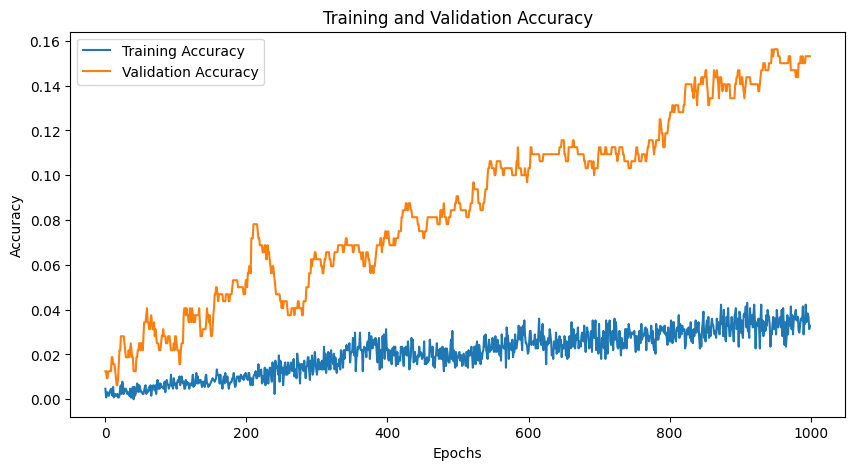

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
